In [353]:
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS
import pandas as pd

In [354]:
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u

### WCS Check

In [383]:
hdu = fits.open('pos_calibrated_r_M22_B_8min_stacked.fit')
sci = hdu[0].data
hdr = hdu[0].header

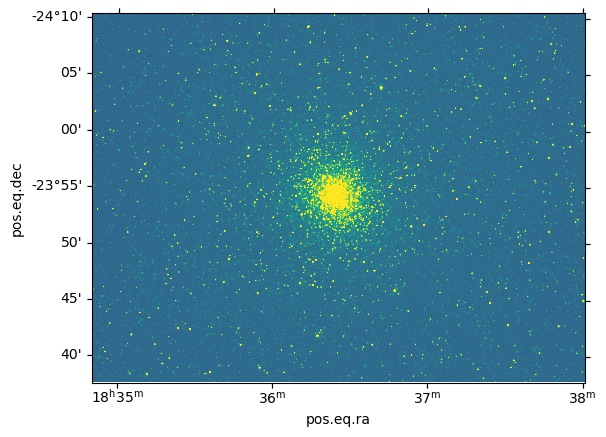

In [335]:
wcs = WCS(hdr)
ax = plt.subplot(projection=wcs)
vmin, vmax = ZScaleInterval().get_limits(sci)
# plt.figure(dpi=200)
ax.imshow(sci, origin='lower', vmin=vmin, vmax=vmax)

plt.show()

In [384]:
def plot_image(data):
    vmin, vmax = ZScaleInterval().get_limits(data)
    plt.figure(dpi=200)
    plt.imshow(data, origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

### SExtractor

In [385]:
SEx_files = sorted(glob('*.ASC'))
print(SEx_files)
namelist = []
for i in range(len(SEx_files)):
    sym="_"
    namelist.append(sym.join(SEx_files[i].split('_')[2:5]))
print(namelist)

['detection_pos_M22_B_30sec_stacked.fit.ASC', 'detection_pos_M22_B_8min_stacked.fit.ASC', 'detection_pos_M22_V_30sec_stacked.fit.ASC', 'detection_pos_M22_V_5min_stacked.fit.ASC']
['M22_B_30sec', 'M22_B_8min', 'M22_V_30sec', 'M22_V_5min']


In [386]:
class StarCluster:
    def __init__(self, filename):
        self.filename = filename
        self.name = filename.split('_')[2]
        self.filter = filename.split('_')[3]
        if filename.split('_')[4]=='1sec':
            self.exptime = 1
        elif filename.split('_')[4]=='5sec':
            self.exptime = 5
        elif filename.split('_')[4]=='30sec':
            self.exptime = 30
        elif filename.split('_')[4]=='5min':
            self.exptime = 300
        elif filename.split('_')[4]=='8min':
            self.exptime = 480
        
    def get_data(self):
        with open(self.filename) as file:
            data = file.readlines()
            data = data[16:]
            rows = len(data)
            cols = len(data[0].split())
            numeric_data = np.zeros((rows, cols))
            for i, line in enumerate(data):
                numeric_data[i] = list(map(float, line.split()))
            self.data = numeric_data
            
    def get_star(self,SNr):
        SNR = self.data[:,17]/self.data[:,18]
        self.star = np.where(np.array(SNR)>=SNr)[0]
        self.mag = -2.5*np.log10(self.data[self.star,17])
        self.star = self.star[np.where(np.logical_and(np.isnan(self.star)==False,np.isnan(self.mag)==False))[0]]
        self.mag = -2.5*np.log10(self.data[self.star,17])
        self.star_ra, self.star_dec = self.data[self.star,1], self.data[self.star,2]
        return self.star, self.mag
    
    def get_new_star(self,star):
        self.star_n = self.star[star]
        self.mag_n = -2.5*np.log10(self.data[self.star_n,17])
        # self.star_n = self.star_n[np.where(np.logical_and(np.isnan(self.star_n)==False,np.isnan(self.mag_n)==False))]
        # self.mag_n = -2.5*np.log10(self.data[self.star_n,17])
        self.star_ra_n, self.star_dec_n = self.data[self.star_n,1], self.data[self.star_n,2]
    
    def write_reg(self,star):
        f = open(self.filename+"_reg.txt", 'w')
        f.write('# Region file format: DS9 version 4.1\n')
        f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
        f.write('fk5\n')
        for i in star:
            f.write('circle('+str(self.data[i,1])+','+str(self.data[i,2])+',1.500")\n')
        f.close()

In [387]:
ClusterP = {}
for i in range(len(SEx_files)):
    ClusterP[namelist[i]] = StarCluster(SEx_files[i])


In [388]:
class APASSStar:
    def __init__(self, filename):
        self.filename = filename
        self.name = filename.split('_')[0]
        
    def get_data(self):
        with open(self.filename) as file:
            df = pd.read_csv(self.filename)
            # print(df.info())
            # print(len(df))
            df2 = df.dropna(subset=['radeg','decdeg','Johnson_V (V)','Johnson_B (B)'])#inplace=True
            # print(len(df2))
            data = (df2.to_numpy())
            self.data = data
    def get_star(self):
        Johnson_V,Johnson_B = self.data[:,4], self.data[:,7]
        apass_ra, apass_dec = self.data[:,0], self.data[:,2]
        self.V, self.B, self.ra, self.dec = Johnson_V, Johnson_B, apass_ra, apass_dec
    def write_reg(self):
        f = open(self.filename+"_reg.txt", 'w')
        f.write('# Region file format: DS9 version 4.1\n')
        f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
        f.write('fk5\n')
        for i in range(len(self.data[:,0])):
            f.write('circle('+str(self.data[i,0])+','+str(self.data[i,2])+',3.000")\n')
        f.close()

In [389]:
APASS_IF = {"name":['APASS_M22'],"filename":['M22apass_279.108753333333_-23.9022436111111_0.5.csv']}
APASS = {}
for i in range(len(APASS_IF["name"])):
    APASS[APASS_IF["name"][i]] = APASSStar(APASS_IF["filename"][i])

In [390]:
def crossmatch(apass_ra,apass_dec,star_ra,star_dec,imp):
    search_apass_index = []
    search_star_index = []
    count = 0
    for i in range(len(apass_ra)):
        search_x = np.abs(star_ra-apass_ra[i])
        search_y = np.abs(star_dec-apass_dec[i])
        search = np.intersect1d(np.where(search_x<=1./3600.*imp)[0],np.where(search_y<=1./3600.*imp)[0])
        if len(search)==1:
            search_apass_index.append(i)
            d=(search_x[search]**2+search_y[search]**2)**0.5
            # print(d)
            search_star_index.append(search)
            count += 1
    # print(count)
    print(len(search_star_index))
    print(len(search_apass_index))
    return search_apass_index,search_star_index
def write_crossmatch(filename,apass_ra,apass_dec,search_apass_index):
    f = open(filename+"search_reg.txt", 'w')
    f.write('# Region file format: DS9 version 4.1\n')
    f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    f.write('fk5\n')
    for i in search_apass_index:
        f.write('circle('+str(apass_ra[i])+','+str(apass_dec[i])+',10.000")\n')
    f.close()

In [391]:
# Use astropy cross match the stars within r (default = 0.5")"
def astro_cross_apass(apass_ra,apass_dec,star_ra,star_dec,r=0.5):
    catalog = SkyCoord(ra=star_ra.astype('float')*u.degree, dec=star_dec.astype('float')*u.degree)
    apass_catalog = SkyCoord(ra=apass_ra*u.degree, dec=apass_dec*u.degree)
    idx_star, idx_apass, d2d, d3d = apass_catalog.search_around_sky(catalog, r*u.arcsec)
    print(len(idx_star), len(idx_star)==len(set(idx_star)))
    print(len(idx_star),len(idx_apass))
    return  idx_apass,idx_star

In [392]:
# Find the real magnitude
def plot_mag(ClusterP, apass,search_apass_index,search_star_index):
    mag, star, filter, name = ClusterP.mag_n, ClusterP.star_n, ClusterP.filter, ClusterP.filename
    mag_s = mag[search_star_index]
    if filter == 'B':
        st_mag = apass.B[search_apass_index]
    elif filter == 'V':
        st_mag = apass.V[search_apass_index]

    delt = mag_s-st_mag
    x=st_mag
    print("----------")
    print("instrument median mag: ",np.median(mag_s))
    median_delt = np.median(delt[np.where(np.isnan(delt)==False)])

#plot
    plt.scatter(mag_s,delt,c='blue')
    plt.axhline(median_delt,c='cyan',label='median delta_mag')
    plt.xlabel('instrument_magnitude')
    plt.ylabel('delta_magnitude')
    plt.title(name)
    plt.legend()
    corr_mag = mag[np.where(np.isnan(mag)==False)]-median_delt
    print("corrected median mag: ",np.median(corr_mag))
    return corr_mag,delt,median_delt

In [393]:
for i in APASS:
    print(i)
    APASS[i].get_data()
    APASS[i].get_star()
    # APASS[i].write_reg()
    

APASS_M22


In [394]:
for i in ClusterP:
    ClusterP[i].get_data()
    star,mag = ClusterP[i].get_star(5)
    print(i)
    # ClusterP[i].write_reg(ClusterP[i].star)

M22_B_30sec
M22_B_8min
M22_V_30sec
M22_V_5min


In [395]:
M22_B_30sec_i,M22_V_30sec_i = astro_cross_apass(ClusterP['M22_B_30sec'].star_ra,ClusterP['M22_B_30sec'].star_dec,
                                             ClusterP['M22_V_30sec'].star_ra,ClusterP['M22_V_30sec'].star_dec)
M22_B_8min_i,M22_V_5min_i = astro_cross_apass(ClusterP['M22_B_8min'].star_ra,ClusterP['M22_B_8min'].star_dec,
                                             ClusterP['M22_V_5min'].star_ra,ClusterP['M22_V_5min'].star_dec)


81567 True
81567 81567
97435 True
97435 97435


In [396]:
ClusterP['M22_B_30sec'].get_new_star(M22_B_30sec_i)
ClusterP['M22_B_8min'].get_new_star(M22_B_8min_i)
ClusterP['M22_V_30sec'].get_new_star(M22_V_30sec_i)
ClusterP['M22_V_5min'].get_new_star(M22_V_5min_i)

# cluster_instance = ClusterP['M22_B_30sec']
# cluster_instance.get_data()
# cluster_instance.get_star(M22_B_30sec_i)
# star_ra_n, star_dec_n = cluster_instance.get_new_star(M22_B_30sec_i)

# cluster_instance = ClusterP['M22_B_8min']
# cluster_instance.get_data()
# cluster_instance.get_star(M22_B_8min_i)
# star_ra_n, star_dec_n = cluster_instance.get_new_star(M22_B_8min_i)

# cluster_instance = ClusterP['M22_V_30sec']
# cluster_instance.get_data()
# cluster_instance.get_star(M22_V_30sec_i)
# star_ra_n, star_dec_n = cluster_instance.get_new_star(M22_V_30sec_i)

# cluster_instance = ClusterP['M22_V_5min']
# cluster_instance.get_data()
# cluster_instance.get_star(M22_V_5min_i)
# star_ra_n, star_dec_n = cluster_instance.get_new_star(M22_V_5min_i)


In [402]:
s_apass_ind_list = []
s_star_ind_list = []

# Iterate over each StarCluster instance
for i in ClusterP:
    if ClusterP[i].name == APASS['APASS_M22'].name[:6]:
        a = 'APASS_M22'
        # Perform cross-matching
    search_apass_index, search_star_index = astro_cross_apass(
        APASS[a].ra, APASS[a].dec, ClusterP[i].star_ra_n, ClusterP[i].star_dec_n)

        # Append results to lists
    s_apass_ind_list.append(search_apass_index)
    s_star_ind_list.append(search_star_index)


957 True
957 957
749 True
749 749
924 True
924 924
635 True
635 635


In [403]:
for i in ClusterP:
    print(i)
for i in APASS:
    print(i)

M22_B_30sec
M22_B_8min
M22_V_30sec
M22_V_5min
APASS_M22


In [404]:
def plot_HR(BVp,Vp,b_name,v_name,apassname,b_ind,v_ind,b_ub=-100,v_ub=-101,b_lb=100,v_lb=100):
    corr_mag_b,delt_b,median_delt_b = plot_mag(ClusterP[b_name], APASS[apassname],s_apass_ind_list[b_ind],s_star_ind_list[b_ind])
    ins_mag_b = corr_mag_b+median_delt_b
    plt.title(b_name + " mag correction")
    if b_ub!=-100:
        plt.axvline(b_ub,c='r')
    if b_lb!=100:
        plt.axvline(b_lb,c='orange')
    plt.show()
    corr_mag_v,delt_v,median_delt_v = plot_mag(ClusterP[v_name], APASS[apassname],s_apass_ind_list[v_ind],s_star_ind_list[v_ind])
    ins_mag_v = corr_mag_v+median_delt_v
    plt.title(v_name + " mag correction")
    if v_ub!=-101:
        plt.axvline(v_ub,c='r')
    if v_lb!=100:
        plt.axvline(v_lb,c='orange')
    plt.show()
    b_num = max(b_ub,v_ub)
    if b_num==b_ub:
        bound = np.where(np.logical_and(corr_mag_b>b_num,ins_mag_b<b_lb,ins_mag_v<v_lb))
    else:
        bound = np.where(np.logical_and(corr_mag_v>b_num,ins_mag_b<b_lb,ins_mag_v<v_lb))
    plt.scatter(corr_mag_b[bound]-corr_mag_v[bound],corr_mag_v[bound],s=1)
    BVp.append(corr_mag_b[bound]-corr_mag_v[bound])
    Vp.append(corr_mag_v[bound])
    plt.ylim(25,5)
    plt.xlabel('B-V (mag)')
    plt.ylabel('V (mag)')
    plt.show()


In [221]:
def plot_HR(BVp, Vp, b_name, v_name, apassname, b_ind, v_ind, b_ub=-100, v_ub=-101, b_lb=100, v_lb=100):
    # Assuming plot_mag is defined somewhere in your code
    corr_mag_b, delt_b, median_delt_b = plot_mag(ClusterP[b_name], APASS[apassname], s_apass_ind_list[b_ind], s_star_ind_list[b_ind])
    ins_mag_b = corr_mag_b + median_delt_b

    # Plotting B band
    plt.figure()
    plt.title(b_name)
    plt.scatter(ins_mag_b, delt_b, c='blue', label='B band')
    if b_ub != -100:
        plt.axvline(b_ub, c='r', label='Upper Bound')
    if b_lb != 100:
        plt.axvline(b_lb, c='orange', label='Lower Bound')
    plt.xlabel('Instrumental Magnitude')
    plt.ylabel('Delta Magnitude')
    plt.legend()
    plt.show()

    # Assuming plot_mag is defined somewhere in your code
    corr_mag_v, delt_v, median_delt_v = plot_mag(ClusterP[v_name], APASS[apassname], s_apass_ind_list[v_ind], s_star_ind_list[v_ind])
    ins_mag_v = corr_mag_v + median_delt_v

    # Plotting V band
    plt.figure()
    plt.title(v_name)
    plt.scatter(ins_mag_v, delt_v, c='green', label='V band')
    if v_ub != -101:
        plt.axvline(v_ub, c='r', label='Upper Bound')
    if v_lb != 100:
        plt.axvline(v_lb, c='orange', label='Lower Bound')
    plt.xlabel('Instrumental Magnitude')
    plt.ylabel('Delta Magnitude')
    plt.legend()
    plt.show()

    # Plotting Color-Magnitude Diagram
    b_num = max(b_ub, v_ub)
    if b_num == b_ub:
        bound = np.where(np.logical_and(corr_mag_b > b_num, ins_mag_b < b_lb, ins_mag_v < v_lb))
    else:
        bound = np.where(np.logical_and(corr_mag_v > b_num, ins_mag_b < b_lb, ins_mag_v < v_lb))

    plt.figure()
    plt.scatter(corr_mag_b[bound] - corr_mag_v[bound], corr_mag_v[bound], s=1, c='purple', label='Color-Magnitude Diagram')
    BVp.extend(corr_mag_b[bound] - corr_mag_v[bound])
    Vp.extend(corr_mag_v[bound])
    plt.ylim(25, 5)
    plt.xlabel('B-V (mag)')
    plt.ylabel('V (mag)')
    plt.legend()
    plt.show()

----------
instrument median mag:  3.0274528295723164
corrected median mag:  19.66292668101412


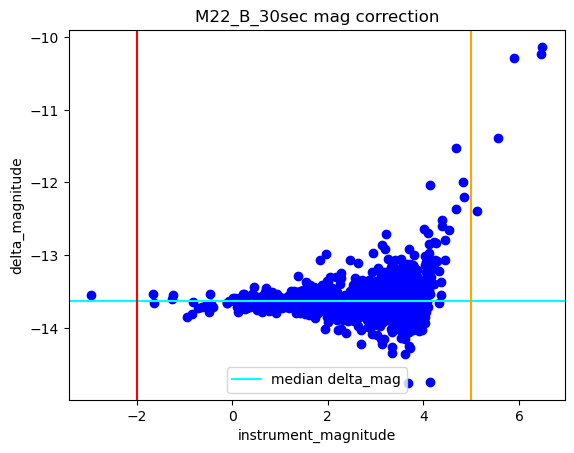

----------
instrument median mag:  1.586322710813204
corrected median mag:  18.5538412588454


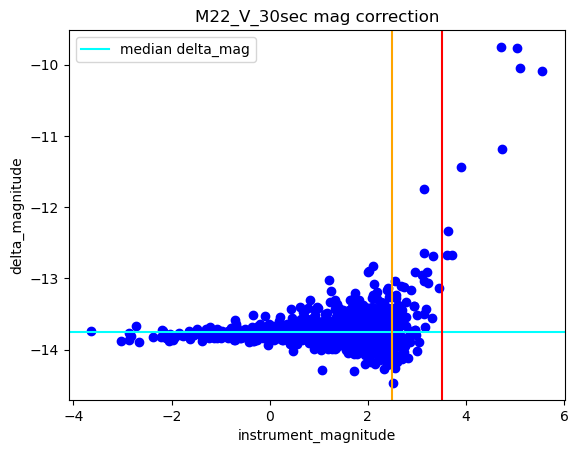

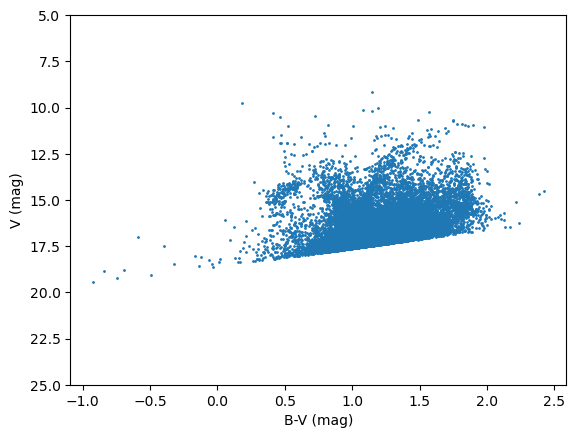

----------
instrument median mag:  -0.050217152730622834
corrected median mag:  20.18907993387896


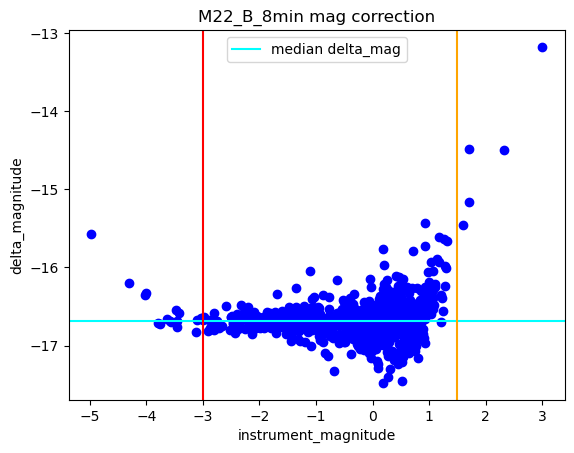

----------
instrument median mag:  -0.9213280285741104
corrected median mag:  19.049453384491535


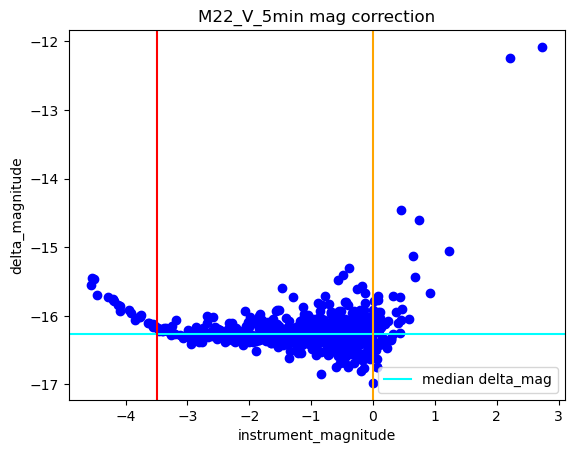

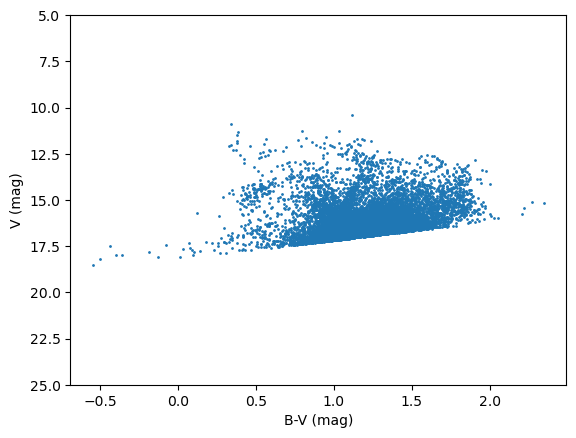

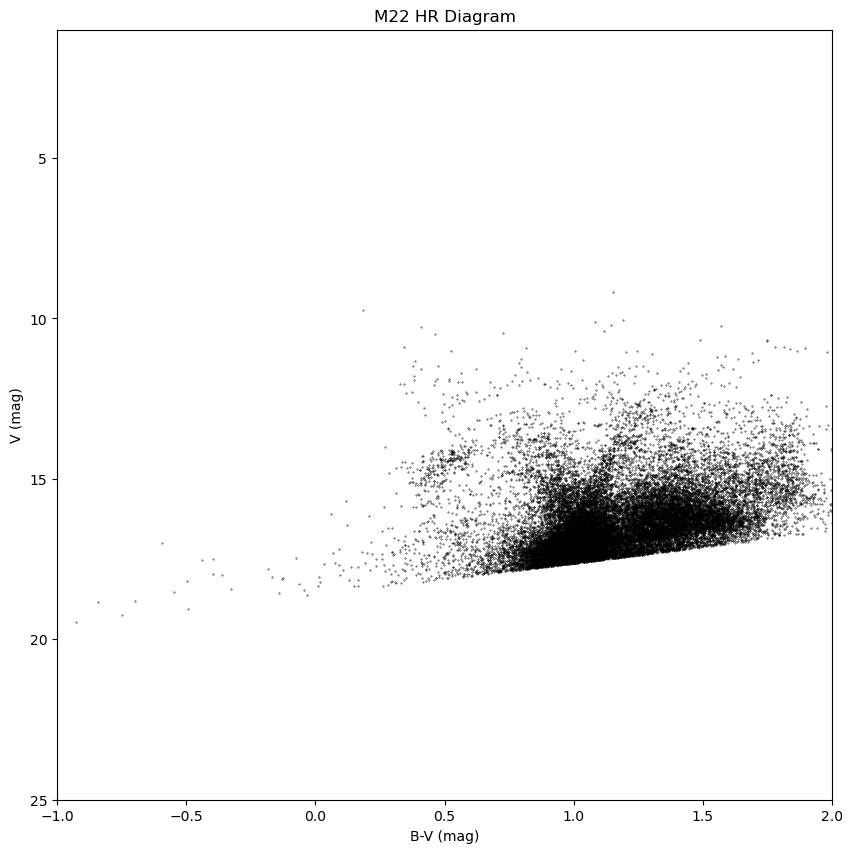

In [410]:
M22_BVp = []
M22_Vp = []

plot_HR(M22_BVp, M22_Vp, 'M22_B_30sec', 'M22_V_30sec', 'APASS_M22', 0, 2, b_ub=-2, v_ub=3.5,v_lb=2.5,b_lb=5)
plot_HR(M22_BVp, M22_Vp, 'M22_B_8min', 'M22_V_5min', 'APASS_M22', 1, 3, b_ub=-3, v_ub=-3.5, b_lb=1.5, v_lb=0)

plt.figure(figsize=(10, 10))
for i in range(len(M22_BVp)):
    plt.scatter(M22_BVp[i], M22_Vp[i], s=0.1, c='k')
    plt.ylim(25, 1)  # Set these outside the loop
    plt.xlim(-1, 2)
    plt.xlabel('B-V (mag)')
    plt.ylabel('V (mag)')
    plt.title('M22 HR Diagram')
plt.show()
